In [1]:
import numpy as np
import pandas as pd

def compute_uq_and_error(true_pckl, pred_pckl, n_models=6):
    """
    Compute energy and force uncertainty and error from true and predicted structures.
    
    Parameters:
        true_pckl (str): Path to the true pickle file (DataFrame format)
        pred_pckl (str): Prefix of prediction files (DataFrame format)
        n_models (int): Number of prediction models/files (default: 6)
    
    Returns:
        dict: Dictionary containing various error and uncertainty metrics
    """
    # Load true structures (DataFrame format)
    true_structs = pd.read_pickle(true_pckl, compression='gzip')
    
    # Extract true values from DataFrame
    pe_true = true_structs['energy'].values
    forces_true = true_structs['forces'].values
    atoms_list = true_structs['ase_atoms'].values
    n_structs = len(true_structs)
    n_atoms = np.array([len(s) for s in atoms_list])

    # Load predicted structures (each is a DataFrame)
    pred_files = [f"{pred_pckl}-{i}_new.pckl.gzip" for i in range(n_models)]
    pred_structs = [pd.read_pickle(f, compression='gzip') for f in pred_files]

    # Build predictions arrays from DataFrames
    pe_preds = [ps['energy'].values for ps in pred_structs]
    force_preds = [ps['forces'].values.tolist() for ps in pred_structs]

    # Energy per-atom calculations
    pe_true_pa = pe_true / n_atoms
    pe_preds_pa = [p / n_atoms for p in pe_preds]
    pe_matrix = np.stack(pe_preds_pa, axis=0)
    
    pe_mean = pe_matrix.mean(axis=0)
    pe_std = pe_matrix.std(axis=0)
    pe_max_dev = np.max(np.abs(pe_matrix - pe_mean), axis=0)
    pe_error = np.abs(pe_mean - pe_true_pa)

    # Force UQ and error calculations
    all_atom_uq = []
    all_atom_error = []
    struct_max_uq = []
    struct_max_error = []

    for j in range(n_structs):
        # Stack predictions from all models for this structure
        preds = np.stack([force_preds[m][j] for m in range(n_models)], axis=0)
        true_f = np.array(forces_true[j])
        mean_pred = preds.mean(axis=0)
        
        # Calculate deviations and errors
        devs = np.linalg.norm(preds - mean_pred[None, :, :], axis=2)
        uq_atom = devs.max(axis=0)
        err_atom = np.linalg.norm(mean_pred - true_f, axis=1)

        all_atom_uq.extend(uq_atom.tolist())
        all_atom_error.extend(err_atom.tolist())
        struct_max_uq.append(uq_atom.max())
        struct_max_error.append(err_atom.max())

    return {
        'pe_true_pa': pe_true_pa,
        'pe_mean': pe_mean,
        'pe_std': pe_std,
        'pe_max_dev': pe_max_dev,
        'pe_error': pe_error,
        'all_atom_uq': np.array(all_atom_uq),
        'all_atom_error': np.array(all_atom_error),
        'struct_max_uq': np.array(struct_max_uq),
        'struct_max_error': np.array(struct_max_error)
    }

In [2]:

# import numpy as np
# import os

# ace_list = ['FN-15', 'FN-30', 'FN-50', 'FN-100', 'FN-300', 'FN-all']
# base_out = "uq_results_by_ace"

# for iace in ace_list:
#     r1 = compute_uq_and_error("group1.pckl.gzip", f"Res/{iace}-group1", n_models=6)
#     r2 = compute_uq_and_error("group2.pckl.gzip", f"Res/{iace}-group2", n_models=6)
#     # r3 = compute_uq_and_error("group3.pckl.gzip", f"Res/{iace}-group3", n_models=6)

#     # pack the eight metrics
#     values = {
#         "g1_pe_error":         r1["pe_error"],
#         "g1_pe_std":           r1["pe_std"],
#         "g1_pe_max_dev":       r1["pe_max_dev"],
#         "g1_struct_max_uq":    r1["struct_max_uq"],
#         "g1_struct_max_error": r1["struct_max_error"],
#         "g1_all_atom_uq":      r1["all_atom_uq"],
#         "g1_all_atom_error":   r1["all_atom_error"],
#         "g2_pe_error":         r2["pe_error"],
#         "g2_pe_std":           r2["pe_std"],
#         "g2_pe_max_dev":       r2["pe_max_dev"],
#         "g2_struct_max_uq":    r2["struct_max_uq"],
#         "g2_struct_max_error": r2["struct_max_error"],
#         "g2_all_atom_uq":      r2["all_atom_uq"],
#         "g2_all_atom_error":   r2["all_atom_error"],
#   }

#     out_dir = os.path.join(base_out, f"ace_{iace}")
#     os.makedirs(out_dir, exist_ok=True)

#     for metric, val in values.items():
#         fn = os.path.join(out_dir, f"{metric}.txt")
#         with open(fn, "w") as f:
#             if isinstance(val, np.ndarray):
#                 f.write(" ".join(f"{v:.6f}" for v in val))
#             else:
#                 f.write(f"{val:.6f}")


In [2]:
import os
import numpy as np
base_out = "uq_results_by_FN_all_num"

mtp_num = range(3, 31, 1)
for imtp in mtp_num:
    # compute for both groups
    # r1 = compute_uq_and_error("group1.cfg", f"mtp-24/group1", n_models=imtp)
    # r2 = compute_uq_and_error("group2.cfg", f"mtp-24/group2", n_models=imtp)
    r1 = compute_uq_and_error("group1.pckl.gzip", f"Res/FN-all-group1", n_models=imtp)
    r2 = compute_uq_and_error("group2.pckl.gzip", f"Res/FN-all-group2", n_models=imtp)
    # pack the eight metrics
    values = {
        "g1_pe_error":         r1["pe_error"],
        "g1_pe_std":           r1["pe_std"],
        "g1_pe_max_dev":       r1["pe_max_dev"],
        "g1_struct_max_uq":    r1["struct_max_uq"],
        "g1_struct_max_error": r1["struct_max_error"],
        "g1_all_atom_uq":      r1["all_atom_uq"],
        "g1_all_atom_error":   r1["all_atom_error"],
        "g2_pe_error":         r2["pe_error"],
        "g2_pe_std":           r2["pe_std"],
        "g2_pe_max_dev":       r2["pe_max_dev"],
        "g2_struct_max_uq":    r2["struct_max_uq"],
        "g2_struct_max_error": r2["struct_max_error"],
        "g2_all_atom_uq":      r2["all_atom_uq"],
        "g2_all_atom_error":   r2["all_atom_error"],
    }

    out_dir = os.path.join(base_out, f"mtp_{imtp}")
    os.makedirs(out_dir, exist_ok=True)

    for metric, val in values.items():
        fn = os.path.join(out_dir, f"{metric}.txt")
        with open(fn, "w") as f:
            if isinstance(val, np.ndarray):
                f.write(" ".join(f"{v:.6f}" for v in val))
            else:
                f.write(f"{val:.6f}")

In [13]:
mtp_num = range(3, 31, 3)
for i in mtp_num:
    print(i)

3
6
9
12
15
18
21
24
27
30


NameError: name 'spearmanr' is not defined

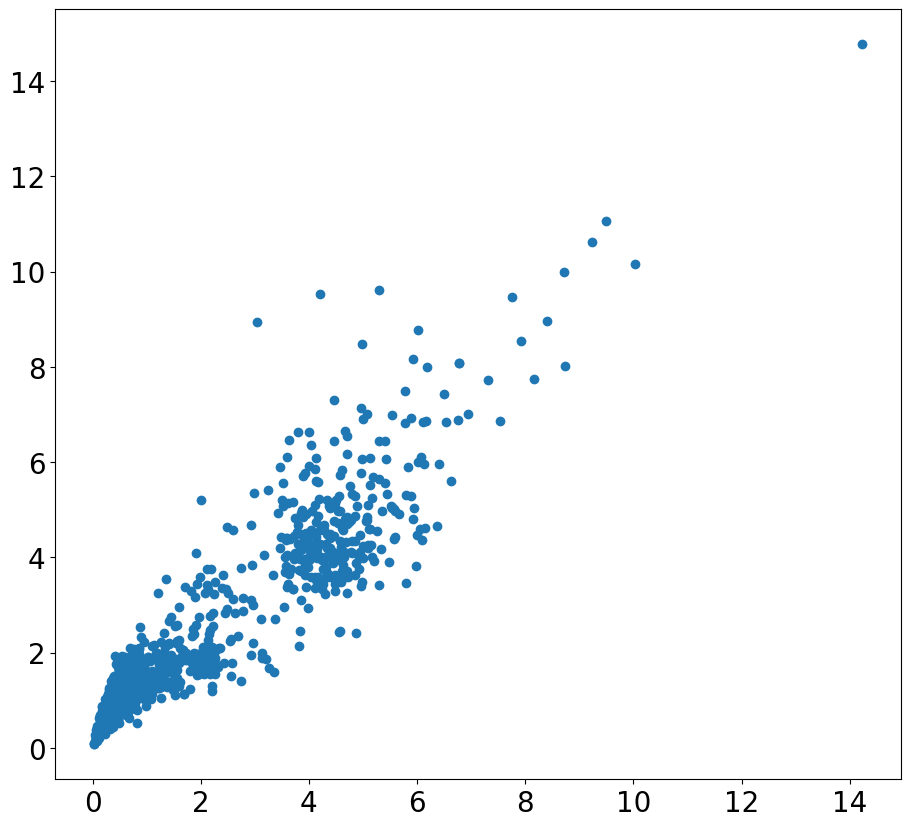

In [5]:
import matplotlib.pyplot as plt

def plot_uq_results(results_list, labels, colors=None, filename='UQ_analysis_maxdev_vector.png', figsize=(24,10)):
    """
    Plot UQ vs error for structure-level and atom-level comparisons, using distinct colors for each dataset.

    Parameters:
    - results_list: list of dicts, each containing keys:
        'struct_max_uq', 'struct_max_error', 'all_atom_uq', 'all_atom_error'
    - labels: list of strings for each results dict
    - colors: list of color specifications (hex, named, RGB) matching the length of results_list; if None, default cycle is used
    - filename: output file for saving the figure
    - figsize: size of the matplotlib figure
    """
    # Create figure and set global fonts
    plt.figure(figsize=figsize)
    plt.rcParams.update({
        'font.size': 24,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 20
    })

    # Determine colors
    if colors is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key().get('color', [])
    # Ensure we have enough colors
    if len(colors) < len(results_list):
        raise ValueError('Not enough colors provided for the number of datasets.')

    # (a) Structure-level Max Deviation vs Error
    ax1 = plt.subplot(1, 2, 1)
    for i, (res, label) in enumerate(zip(results_list, labels)):
        ax1.scatter(
            res['struct_max_uq'], res['struct_max_error'],
            alpha=1, label=label, color=colors[i]
        )
        print(spearmanr(res['struct_max_uq'], res['struct_max_error']))
        print(spearmanr(res['all_atom_uq'], res['all_atom_error']))
    
    ax1.set_xlabel('Max Force Deviation in Structure (eV/Å)')
    ax1.set_ylabel('Max Force Error in Structure (eV/Å)')
    ax1.grid(alpha=1)
    ax1.legend(loc='best')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-2, 5e1)  # Set x-axis range from 0.001 to 10
    ax1.set_ylim(1e-2, 5e1)  # Set y-axis range from 0.001 to 10

    # (b) Atom-level Max Deviation vs Error
    ax2 = plt.subplot(1, 2, 2)
    for i, (res, label) in enumerate(zip(results_list, labels)):
        ax2.scatter(
            res['all_atom_uq'], res['all_atom_error'],
            alpha=1, s=16, label=label, color=colors[i]
        )
        print(spearmanr(res['struct_max_uq'], res['struct_max_error']))
        print(spearmanr(res['all_atom_uq'], res['all_atom_error']))
    ax2.set_xlabel('Force Deviation per Atom (eV/Å)')
    ax2.set_ylabel('Force Error per Atom (eV/Å)')
    ax2.grid(alpha=1)
    ax2.legend(loc='upper left')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-4, 1e2)  # Set x-axis range from 0.001 to 10
    ax2.set_ylim(1e-4, 1e2)  # Set y-axis range from 0.001 to 10
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
plot_uq_results([r2, r1], ['Model A', 'Model B'])

In [14]:
for i in range(3): print(i)

0
1
2
